<i> Note: This notebook is inspired by the Word Embedding using Word2vec series at: 
    https://github.com/rhasanbd/Word-Embedding-by-Word2vec </i>

# Word Embedding

- Word embedding is the collective name for a set of language modeling and feature learning techniques in NLP where words or phrases from the vocabulary are **mapped to vectors of real numbers**. 

- Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text.
- eg. For Apple(Fruit) and Apple(Company)

## Word2vec Methods

- Word2vec is a group of related models that are used to produce word embeddings. These methods are **prediction based** in the sense that they provided probabilities to the words. 

- Word2vec has two primary methods of contextualizing words:

 1. Continuous Bag-of-Words model (CBOW)
 2. Skip-Gram model

Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 

from pymongo import MongoClient

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rojin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Explore Data

In [2]:
client = MongoClient("mongodb://localhost:27017/")
db = client.yelp_database
df = pd.DataFrame(db.business_restaurant.find({},{"reviews.text":1, "_id":0}))
df = df.applymap(lambda x : x[0]['text'])
df.head() #Quick Check of the data

,reviews
0,During the recent Yelp scavenger hunt event my...
1,Bolt is within walking distance of The Drake H...
2,Apteka was one the highest rated places I have...
3,"When people say Korean food, what do you think..."
4,I'm SO glad I finally got to get SERVED last w...


## Description of the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8688 entries, 0 to 8687
Data columns (total 1 columns):
reviews    8688 non-null object
dtypes: object(1)
memory usage: 68.0+ KB


## Dimension the Data

In [4]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (8688, 1)
No. of Rows: 8688
No. of Columns: 1


## Convert the DataFrame Object into a 2D Array of Documents

We convert the documents from DataFrame object to an array of documents.

It's a 2D array in which each row reprents a document.

In [5]:
docs_array = np.array(df['reviews']) # Convert the 'text' column into array

print("Dimension of the documents array: ", docs_array.shape) # View dimensions of new array

print(docs_array[2]) # Display the first document

Dimension of the documents array:  (8688,)
Apteka was one the highest rated places I have bookmarked for a while.  I definitely do not share the views of others for this establishment.  We arrived there and the first thing they say is the the kitchen folks are taking a break so we could not order for another 20 mins.  Okay, so we went to sit down and wait till it is time.  We proceeded to order:

Bababurger and fries.  Presentation-wise, looked good.  The bread was extremely dense and was hard to bite through.  We had a hard time cutting it in half with a knife for sharing.  The patty had next to no flavor and the texture was odd when eaten with the hard bread.  

Perogies plate (spicy) - this was better than the bababurger but all you could taste is spice and overwhelms the different stuffings for each one.

The only highlight of the night were the fries as they tasted freshly cut and fried.  However, halfway through we got tired of it; maybe due to our palates being numbed from the f

## Pre-process the Data

Pre-processing of the text data is done using the following steps:

- Convert to lowercase 
- Tokenize (split the documents into tokens or words)
- Remove numbers, but not words that contain numbers
- Remove words that are only a single character
- Lemmatize the tokens/words


### Tokenization and Lemmatization

- We convert all the words into lowercase then tokenize each word using NLTK Regular-Expression Tokenizer class "RegexpTokenizer". 
- It splits a given string to substrings using a regular expression. 
- Then we remove numbers and single character words since they usually don't impart much useful information and are very high in number.
- Finally, we lemmatize the tokens using WordNetLemmatizer from NLTK, where we extract the root words of the tokens using the dictionary.

In [6]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    '''Function to Convert the 2D Document Array into a 2D Array of Tokenized Documents'''
    tokenizer = RegexpTokenizer(r'\w+') # Tokenize the words.
    
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [7]:
# Convert a list of sentences to a list of lists containing tokenized words
%time docs = docs_preprocessor(docs_array)

Wall time: 8.01 s


In [8]:
print("Length of the 2D Array of Tokenized Documents: ", len(docs))

Length of the 2D Array of Tokenized Documents:  8688


## Remove all stop words
- Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text. 
- The stop words may be removed to avoid them being construed as signal for prediction.
- To remove the stop words, we use the "stopwords" module from the nltk library.

In [9]:
# Load library
from nltk.corpus import stopwords

# You will have to download the set of stop words the first time
import nltk
nltk.download('stopwords')

# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rojin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

In [10]:
# Remove all stop words from the doc
for i in range(len(docs)):
    docs[i] = [word for word in docs[i] if word not in stop_words]

## Compute Bigrams/Trigrams:

- N-grams are combinations of adjacent words or letters of length 'n' that you can find in your source text. These combinations of words carry a special meaning. For example: car-pool is an n-gram formed using the two words car and pool that carries a distinct meaning different from the individual words. 

- If n=2, it is called a Bigram and if n=3, it is called a Trigram.

- We find all the combinations of Bigrams and Trigrams. Then, we keep only the frequent phrases. 
- We finally add the frequent phrases to the original data, since we would like to keep the words “car” and “pool” as well as the bigram “car_pool”.

In [12]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10, threshold=100)
trigram = Phrases(bigram[docs], min_count=10,  threshold=100)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

## Training the Word2vec Model

We use the gensim.models.Word2Vec class.

        class gensim.models.word2vec.Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)

We need to set the parameters of the Word2Vec object carefully. The full list of the parameters are given: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
# Set training parameters
size = 140       # Dimension of the word vector
window = 2  # We set it 2 as the sentences weren't too long
epochs = 500     # Number of iterations (epochs) over the corpus.
min_count = 100    # Ignores all words with total frequency lower than this.
workers = 4 #Use these many worker threads to train the model (=faster training with multicore machines)

# Train Word2vec model using gensim (use the skip-gram model: sg = 1; otherwise CBOW.)
%time model = Word2Vec(docs, sg=1, window=window, min_count=min_count,  workers=workers, iter=epochs) #,sample=0.01

## Save the Model Locally

In [ ]:
model.save('w2v_model_yelp_review')

## Load the Saved Model

In [ ]:
# load word2vec model
model = Word2Vec.load('w2v_model_yelp_review')

## Model Evaluation

There is no easy way to evaluate the trained model.

One approach could be to see whether the model has learned the semantic representation of the words.

For this we use model's "wv" object. It contains the mapping between words and embeddings. It has several methods that we can use for our evaluation.
https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.Word2VecKeyedVectors

## Evaluation 1: Find Similar Words

In [4]:
model.wv.most_similar('restaurant')

[('place', 0.6891217231750488),
 ('business', 0.5820425152778625),
 ('establishment', 0.5753387212753296),
 ('location', 0.5746479630470276),
 ('cuisine', 0.5471142530441284),
 ('eatery', 0.5313606262207031),
 ('area', 0.5248818397521973),
 ('cafe', 0.49210572242736816),
 ('store', 0.4724154770374298),
 ('building', 0.44917553663253784)]

In [5]:
model.wv.most_similar('milk')

[('coffee', 0.5586003065109253),
 ('almond', 0.5159417986869812),
 ('vanilla', 0.4771198630332947),
 ('strawberry', 0.4563044309616089),
 ('coconut', 0.45427215099334717),
 ('sugar', 0.45378971099853516),
 ('matcha', 0.4314887523651123),
 ('tea', 0.42589133977890015),
 ('latte', 0.4252324104309082),
 ('bubble', 0.42409974336624146)]

In [6]:
model.wv.most_similar('drink')

[('bartender', 0.5680417418479919),
 ('water', 0.519067645072937),
 ('beverage', 0.5103083848953247),
 ('cocktail', 0.473637193441391),
 ('coffee', 0.47252923250198364),
 ('beer', 0.46133098006248474),
 ('soda', 0.4534120261669159),
 ('iced', 0.44825202226638794),
 ('refill', 0.4367944002151489),
 ('glass', 0.42993175983428955)]

## Evaluation 2: Find Top N Similar Words

In [7]:
model.wv.similar_by_word('restaurant', topn=5)

[('place', 0.6891217231750488),
 ('business', 0.5820425152778625),
 ('establishment', 0.5753387212753296),
 ('location', 0.5746479630470276),
 ('cuisine', 0.5471142530441284)]

In [8]:
model.wv.similar_by_word('server', topn=5)

[('waitress', 0.7951263189315796),
 ('waiter', 0.7157297134399414),
 ('bartender', 0.5973083972930908),
 ('staff', 0.5932340025901794),
 ('hostess', 0.531126856803894)]

## Evaluation 3: Find Similarity Values

In [9]:
model.wv.similarity("breakfast", "egg")

0.43625984

In [10]:
model.wv.similarity("breakfast", "morning")

0.37976274

In [11]:
model.wv.similarity("breakfast", "bacon")

0.35839173

In [12]:
model.wv.similarity("breakfast", "noodle")

0.10623173

In [13]:
model.wv.similarity("breakfast", "spicy")

0.03859774

## Evaluation 4: Get All Words that are closer to Word 1 than Word 2 

In [14]:
model.wv.closer_than("wonderful", "nice")

['great',
 'delicious',
 'amazing',
 'perfect',
 'excellent',
 'awesome',
 'beautiful',
 'fantastic',
 'interesting',
 'lovely',
 'outstanding']

## Evaluation 5: Perform Vector Translation

In [15]:
model.wv.most_similar(positive=[ 'server', 'staff'], topn=3)  #room,shower, bedroom = bathroom

[('waitress', 0.7249794006347656),
 ('waiter', 0.6622384786605835),
 ('bartender', 0.6289184093475342)]

In [16]:
model.wv.most_similar(positive=['glass', 'bottle'], negative=['water'], topn=3)  #woman, king, man = queen

[('wine', 0.563236653804779),
 ('cocktail', 0.40306854248046875),
 ('beer', 0.40035611391067505)]

In [17]:
model.wv.most_similar(positive=['hotel','room'], topn=3)

[('casino', 0.5725829601287842),
 ('floor', 0.5227464437484741),
 ('bathroom', 0.4735279083251953)]

## Evaluation 6: Word from the given List doesn’t go with the Others

In [18]:
# Which of the below does not belong in the sequence?
model.wv.doesnt_match('restaurant food pool server'.split()) #hotel nice clean holiday

c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'pool'

## Vocabulary

It is important to know the vocabulary size. The "perplexity" parameter of the t-SNE visualization model is set based on this.

In [19]:
print("Vocabulary Size: ", len(model.wv.vocab))

# print("Vocabulary: ")
# for word in model.wv.vocab:
#     print(" ", word)

Vocabulary Size:  1310


## Visualize Word Embedding in 2D using t-SNE

We plot the vocabulary in 2D using t-SNE.

Note that t-SNE would be extremely slow because of the larze size of vocabulary. That's why first we apply PCA to reduce the number of dimensions, then apply t-SNE.

In [125]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = [] # stores the words (labels)
    tokens = [] # stores word vectors

    for word in model.wv.vocab:
        tokens.append(model.wv.__getitem__(word))
        labels.append(word)
        
    pca_tsne = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=42)),
        
        # perplexity should be much smaller than the size of the vocabulary
        ("tsne", TSNE(n_components=2, perplexity=30, random_state=42)),
    ])
    

    new_values = pca_tsne.fit_transform(tokens)


    # get the two coordinates in two lists
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],  # text of the annotation
                     xy=(x[i], y[i]), # The point (x,y) to annotate.
                     xytext=(5, 2),   # The position (x,y) to place the text at. If None, defaults to xy.
                     textcoords='offset points', # The coordinate system that xy text is given in.
                     ha='right', # horizontal alignment
                     va='bottom') # vertical alignment
    plt.xticks([])
    plt.yticks([])
    plt.show()

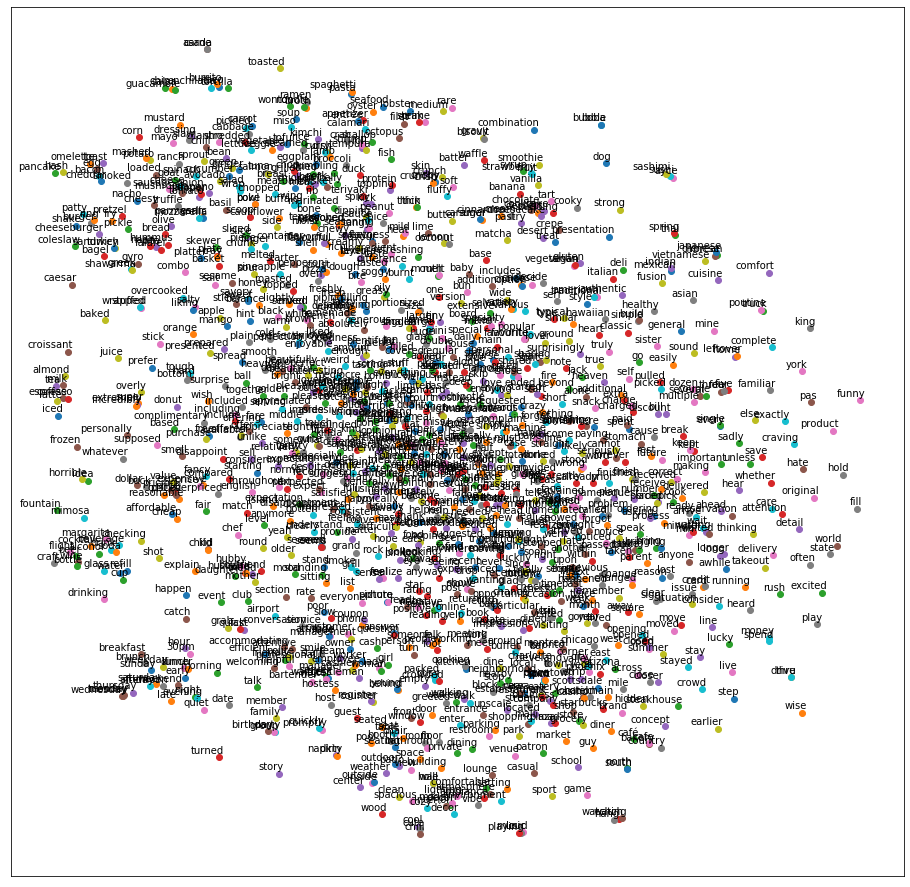

Wall time: 20.2 s


In [126]:
%time tsne_plot(model)

## Creating Useful Visualization

The above 2D plot of the vocabulary is not very useful. Because we plotted all the words, most of which are overlapped.

For meaningful investigation of the semantic relationship among the words, we need to create a subset of the vocabulary for plotting. 

Mini-Vocabulary Size:  30


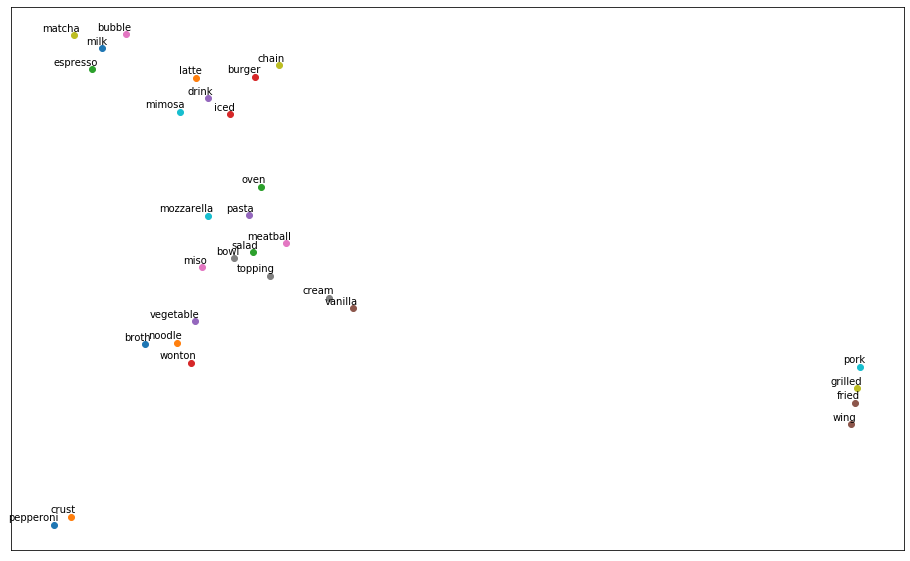

In [43]:
'''
Create a subset of the vocabulary that contains 
- a set of words
- words most similar to these words

'''
key_words = ['soup', 'pizza','coffee']

words = [] # subset of vocabulary

for k in key_words:
    for i in range(len(model.wv.most_similar(k))):
        words.append(model.wv.most_similar(k)[i][0])
        
        
print("Mini-Vocabulary Size: ", len(words))
    
# # Display the vocabulary subset   
# for i in words:
#     print(i)


'''
Visualization by PCA+t-SNE
'''
labels = [] # stores the words (labels)
tokens = [] # stores word vectors
    
    
for word in words:
    tokens.append(model.wv.__getitem__(word))
    labels.append(word)
        
pca_tsne = Pipeline([("pca", PCA(n_components=0.95, random_state=42)),
    
    # perplexity should be much smaller than the size of the vocabulary
    ("tsne", TSNE(n_components=2, perplexity=0.5, random_state=42)), 
])


new_values = pca_tsne.fit_transform(tokens)


# get the two coordinates in two lists
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],  # text of the annotation
                 xy=(x[i], y[i]), # The point (x,y) to annotate.
                 xytext=(5, 2),   # The position (x,y) to place the text at. If None, defaults to xy.
                 textcoords='offset points', # The coordinate system that xy text is given in.
                 ha='right', # horizontal alignment
                 va='bottom') # vertical alignment

plt.xticks([])
plt.yticks([])
plt.show()

Mini-Vocabulary Size:  30


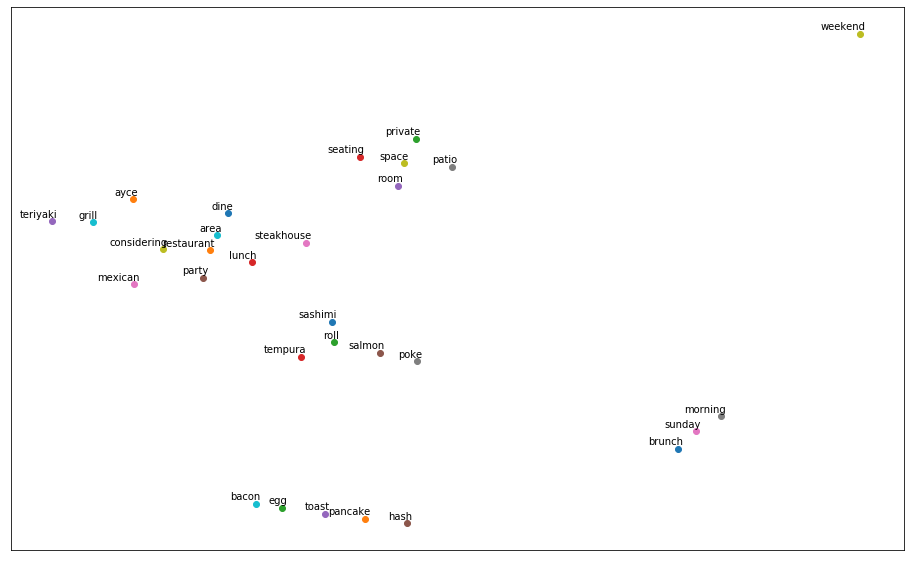

In [45]:
'''
Create a subset of the vocabulary that contains 
- a set of words
- words most similar to these words

'''
key_words = ['dining', 'sushi','breakfast']

words = [] # subset of vocabulary

for k in key_words:
    for i in range(len(model.wv.most_similar(k))):
        words.append(model.wv.most_similar(k)[i][0])
        
        
print("Mini-Vocabulary Size: ", len(words))
    
# # Display the vocabulary subset   
# for i in words:
#     print(i)


'''
Visualization by PCA+t-SNE
'''
labels = [] # stores the words (labels)
tokens = [] # stores word vectors
    
    
for word in words:
    tokens.append(model.wv.__getitem__(word))
    labels.append(word)
        
pca_tsne = Pipeline([("pca", PCA(n_components=0.95, random_state=42)),
    
    # perplexity should be much smaller than the size of the vocabulary
    ("tsne", TSNE(n_components=2, perplexity=0.9, random_state=42)), 
])


new_values = pca_tsne.fit_transform(tokens)


# get the two coordinates in two lists
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],  # text of the annotation
                 xy=(x[i], y[i]), # The point (x,y) to annotate.
                 xytext=(5, 2),   # The position (x,y) to place the text at. If None, defaults to xy.
                 textcoords='offset points', # The coordinate system that xy text is given in.
                 ha='right', # horizontal alignment
                 va='bottom') # vertical alignment

plt.xticks([])
plt.yticks([])
plt.show()

Mini-Vocabulary Size:  30


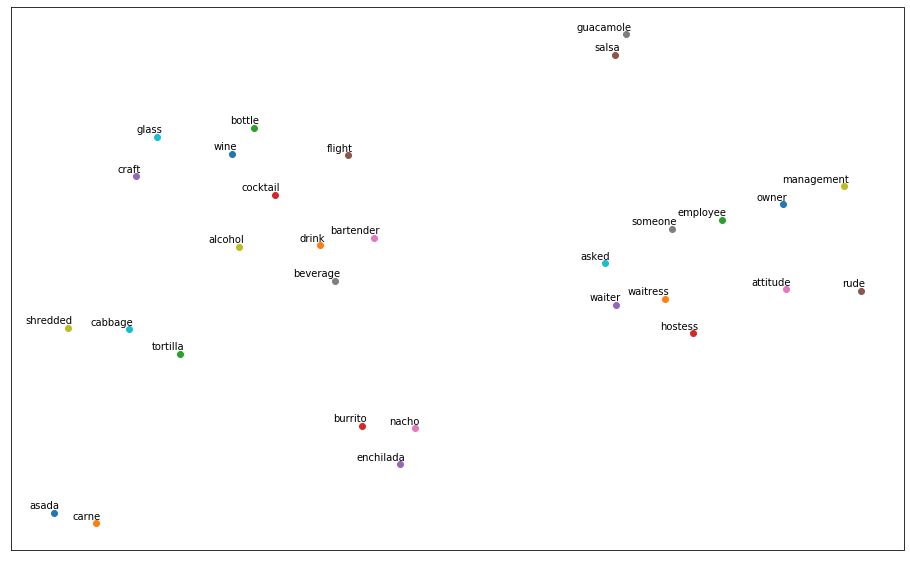

In [48]:
'''
Create a subset of the vocabulary that contains 
- a set of words
- words most similar to these words

'''
key_words = ['beer', 'manager','taco']

words = [] # subset of vocabulary

for k in key_words:
    for i in range(len(model.wv.most_similar(k))):
        words.append(model.wv.most_similar(k)[i][0])
        
        
print("Mini-Vocabulary Size: ", len(words))
    
# # Display the vocabulary subset   
# for i in words:
#     print(i)


'''
Visualization by PCA+t-SNE
'''
labels = [] # stores the words (labels)
tokens = [] # stores word vectors
    
    
for word in words:
    tokens.append(model.wv.__getitem__(word))
    labels.append(word)
        
pca_tsne = Pipeline([("pca", PCA(n_components=0.95, random_state=42)),
    
    # perplexity should be much smaller than the size of the vocabulary
    ("tsne", TSNE(n_components=2, perplexity=3, random_state=42)), 
])


new_values = pca_tsne.fit_transform(tokens)


# get the two coordinates in two lists
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],  # text of the annotation
                 xy=(x[i], y[i]), # The point (x,y) to annotate.
                 xytext=(5, 2),   # The position (x,y) to place the text at. If None, defaults to xy.
                 textcoords='offset points', # The coordinate system that xy text is given in.
                 ha='right', # horizontal alignment
                 va='bottom') # vertical alignment

plt.xticks([])
plt.yticks([])
plt.show()